Data Loading & Preprocessing 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import radians, sin, cos, asin, sqrt

sns.set_style('whitegrid')

# Load the January 2023 data (for full 2023, you need all months combined)
df = pd.read_csv('/Users/sharanabhimanyu/Downloads/202301-citibike-tripdata_1.csv', 
                 parse_dates=['started_at', 'ended_at'], 
                 low_memory=False)

# Filter to 2023 data
df = df[df['started_at'].dt.year == 2023]

# Calculate trip duration in minutes
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60.0


1. Summary Statistics
Task:
In 2023, what is the total number of trips taken, the average trips per day, the average duration per trip, and the percentage of trips taken by annual members?

In [25]:
total_trips = len(df)

# Calculate the number of days in the dataset
days_in_data = (df['started_at'].max().normalize() - df['started_at'].min().normalize()).days + 1
avg_trips_per_day = total_trips / days_in_data if days_in_data > 0 else np.nan

avg_duration = df['trip_duration'].mean()

# Assuming 'member' in 'member_casual' column indicates annual members
member_counts = df['member_casual'].value_counts(normalize=True)*100
percent_member = member_counts.get('member', 0)

print("----- Summary Statistics (2023) -----")
print(f"Total number of trips: {total_trips}")
print(f"Average trips per day: {avg_trips_per_day}")
print(f"Average trip duration (minutes): {avg_duration}")
print(f"Percentage of trips by annual members: {percent_member}%")


----- Summary Statistics (2023) -----
Total number of trips: 999821
Average trips per day: 32252.290322580644
Average trip duration (minutes): 15.213573321424539
Percentage of trips by annual members: 86.69131774587652%


2. Plots of Trips by Month, Day of Week, and Hour of Day
Task:
Based on 2023 trip records, create plots showing the total number of trips taken in:

Each month of the year
Each day of the week
Each hour of the day

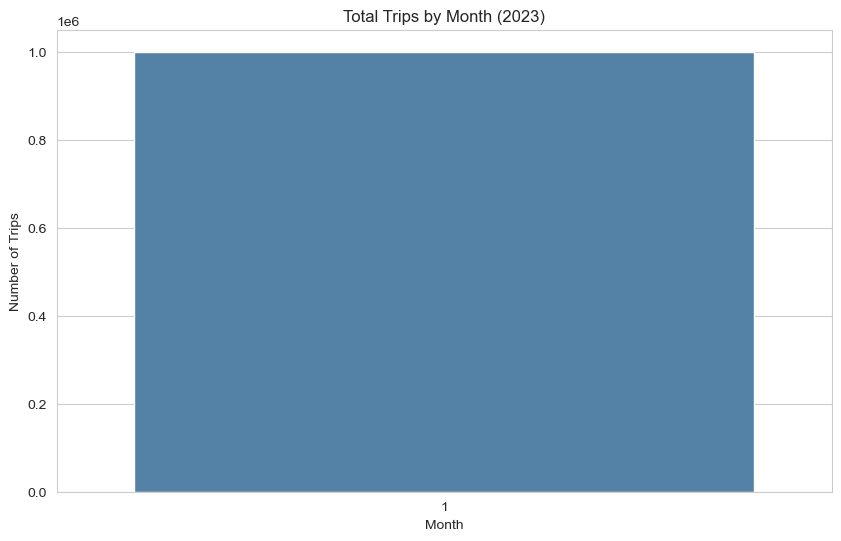

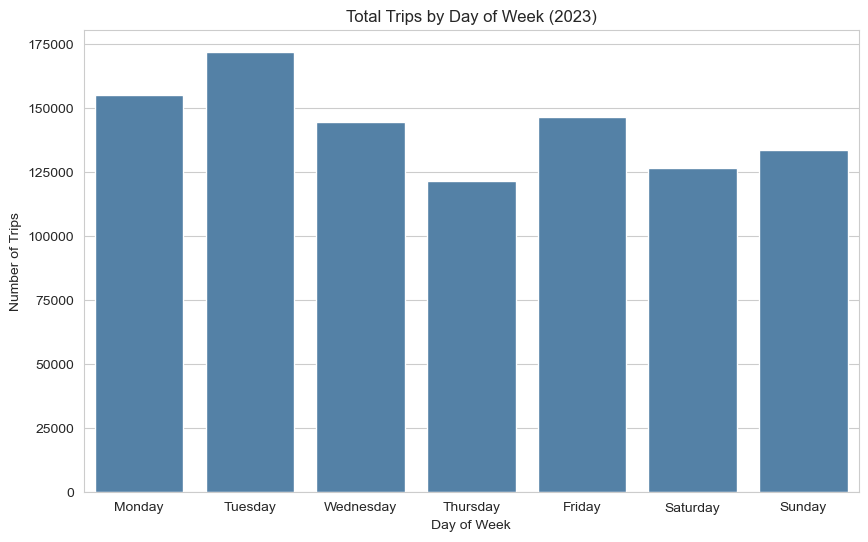

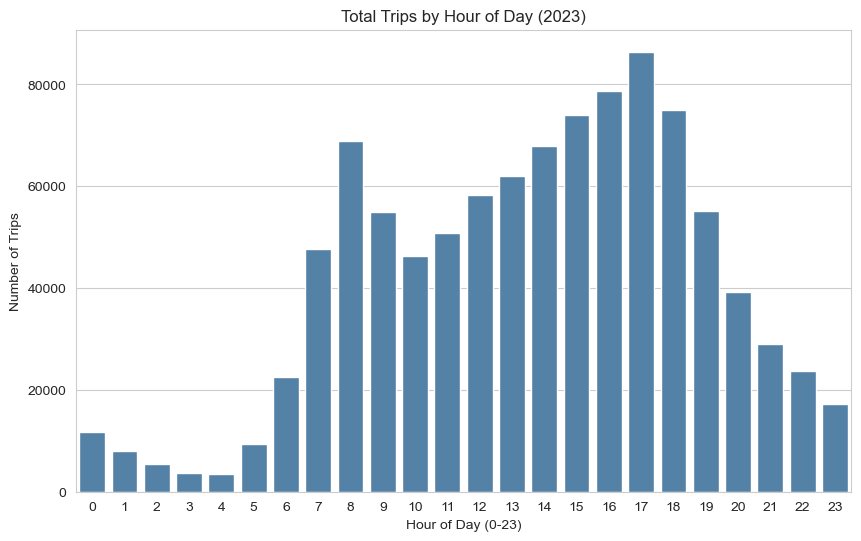

In [27]:
df['month'] = df['started_at'].dt.month
df['day_of_week'] = df['started_at'].dt.day_name()
df['hour'] = df['started_at'].dt.hour

# 2.1 Trips by month
monthly_counts = df.groupby('month').size().reset_index(name='count')
plt.figure(figsize=(10,6))
sns.barplot(x='month', y='count', data=monthly_counts, color='steelblue')
plt.title('Total Trips by Month (2023)')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

# 2.2 Trips by day of the week
order_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_counts = df.groupby('day_of_week').size().reset_index(name='count')
day_counts['day_of_week'] = pd.Categorical(day_counts['day_of_week'], categories=order_days, ordered=True)
day_counts = day_counts.sort_values('day_of_week')
plt.figure(figsize=(10,6))
sns.barplot(x='day_of_week', y='count', data=day_counts, color='steelblue')
plt.title('Total Trips by Day of Week (2023)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.show()

# 2.3 Trips by hour of day
hour_counts = df.groupby('hour').size().reset_index(name='count')
plt.figure(figsize=(10,6))
sns.barplot(x='hour', y='count', data=hour_counts, color='steelblue')
plt.title('Total Trips by Hour of Day (2023)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Trips')
plt.show()


3. Top 10 Stations and Routes
Task:
Find the top 10 most popular stations and top 10 most common bike trip routes in 2023. Show the results using bar charts.

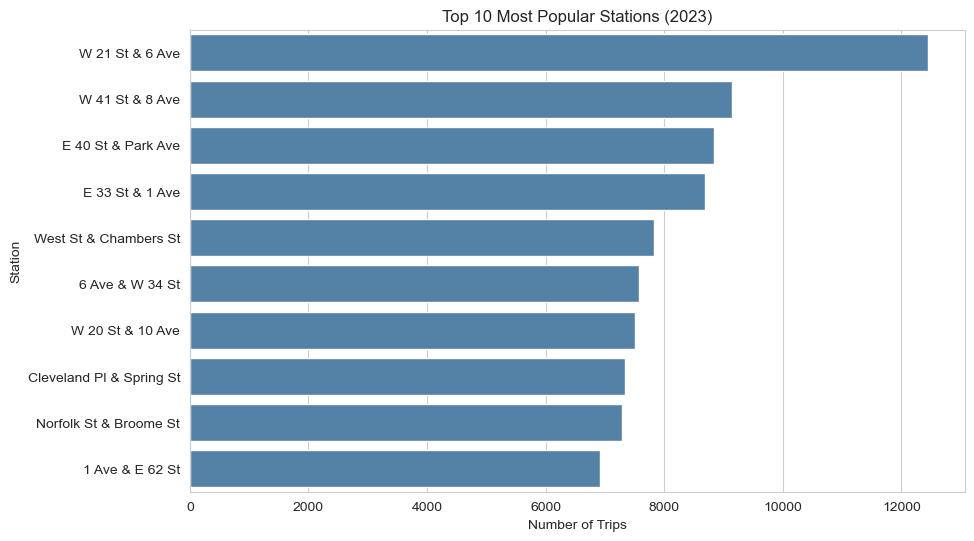

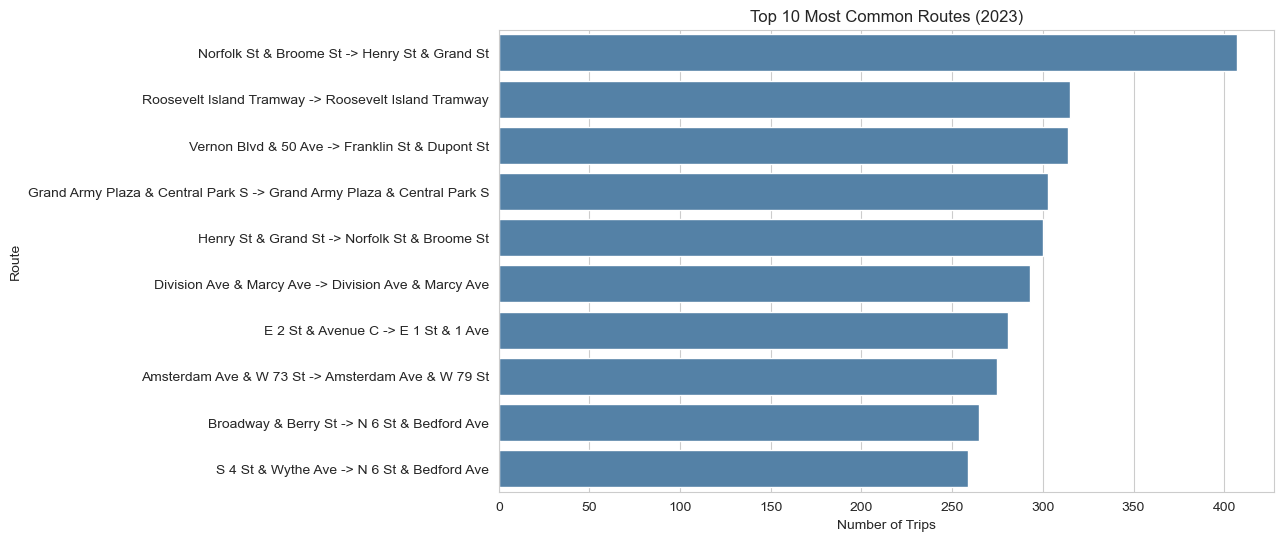

Top station: W 21 St & 6 Ave


In [29]:
# Top 10 stations
start_counts = df.groupby('start_station_name').size()
end_counts = df.groupby('end_station_name').size()
station_usage = start_counts.add(end_counts, fill_value=0)
top_10_stations = station_usage.nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_10_stations.values, y=top_10_stations.index, color='steelblue')
plt.title('Top 10 Most Popular Stations (2023)')
plt.xlabel('Number of Trips')
plt.ylabel('Station')
plt.show()

# Top 10 routes
routes = df.groupby(['start_station_name','end_station_name']).size().reset_index(name='count')
top_10_routes = routes.nlargest(10, 'count')
route_labels = top_10_routes.apply(lambda x: f"{x['start_station_name']} -> {x['end_station_name']}", axis=1)

plt.figure(figsize=(10,6))
sns.barplot(x='count', y=route_labels, data=top_10_routes, color='steelblue')
plt.title('Top 10 Most Common Routes (2023)')
plt.xlabel('Number of Trips')
plt.ylabel('Route')
plt.show()

# Save the name of the top station for the next question
top_station = top_10_stations.index[0]
print("Top station:", top_station)


4. Heatmap of Top Station Usage
Task:
Create a heatmap depicting the average usage of the top bike station (from Q3) at different times of the day.

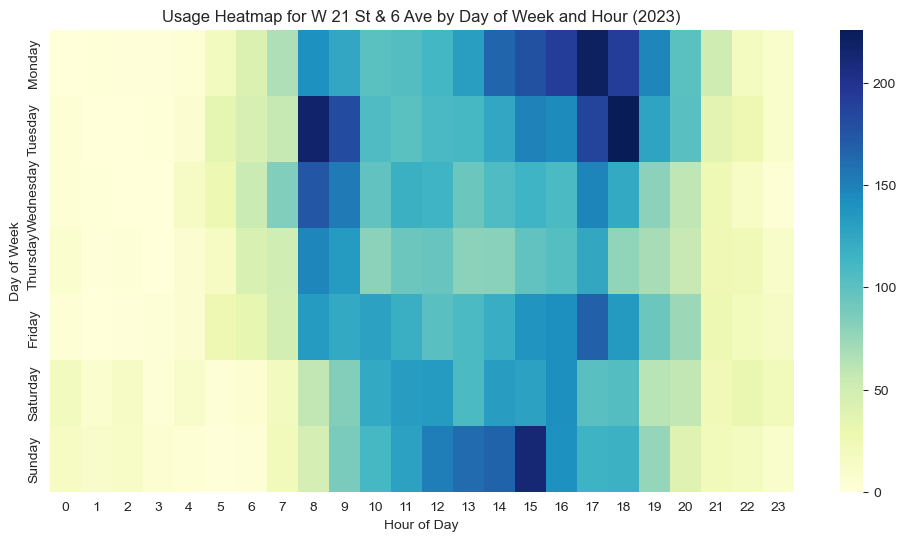

In [32]:
top_station_df = df[(df['start_station_name'] == top_station) | (df['end_station_name'] == top_station)]

heat_data = top_station_df.groupby(['day_of_week','hour']).size().reset_index(name='count')
heat_data['day_of_week'] = pd.Categorical(heat_data['day_of_week'], categories=order_days, ordered=True)
heat_data = heat_data.sort_values('day_of_week')
pivot = heat_data.pivot(index='day_of_week', columns='hour', values='count').fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlGnBu', annot=False, fmt='g')
plt.title(f'Usage Heatmap for {top_station} by Day of Week and Hour (2023)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


5. Relationship Between Trip Duration and Distance
Task:
Is there a relationship between trip duration and the distance between the start and end stations? Present results visually.

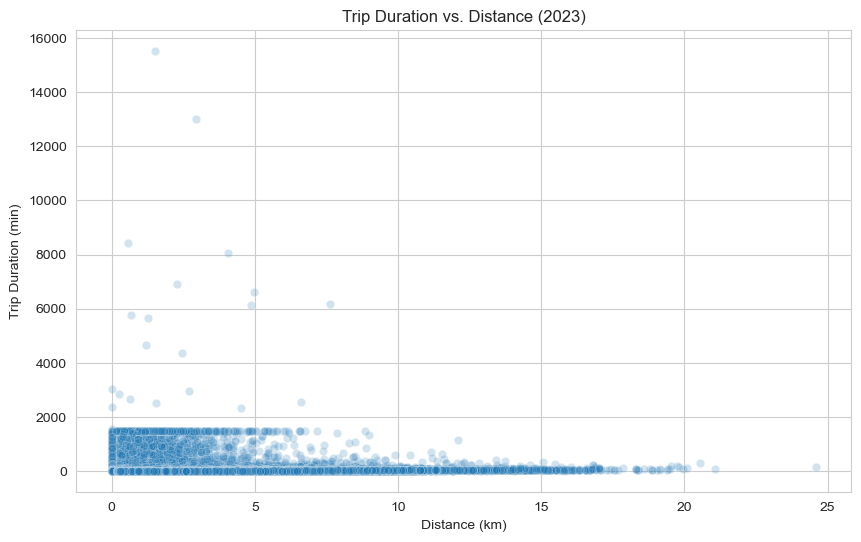

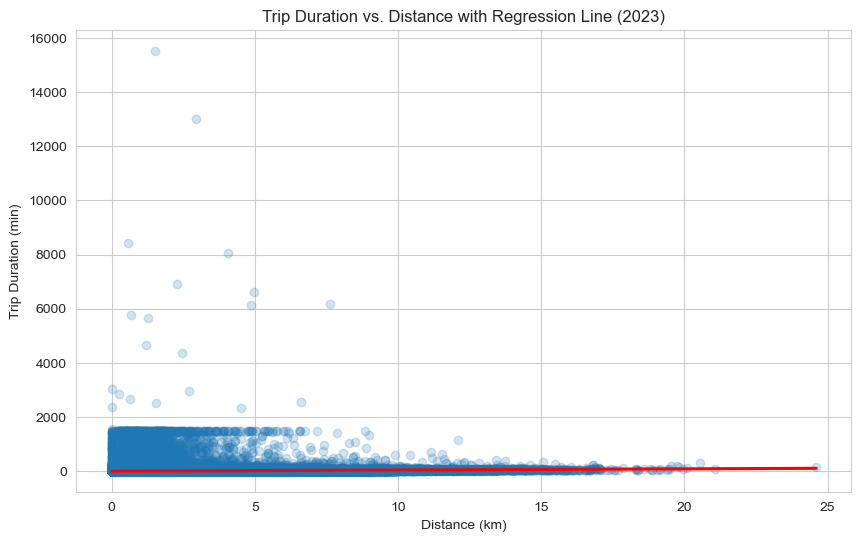

In [34]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

df['distance_km'] = df.apply(lambda x: haversine(x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']), axis=1)

plt.figure(figsize=(10,6))
sns.scatterplot(x='distance_km', y='trip_duration', data=df, alpha=0.2)
plt.title('Trip Duration vs. Distance (2023)')
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (min)')
plt.show()

# Optional: Add a regression line
plt.figure(figsize=(10,6))
sns.regplot(x='distance_km', y='trip_duration', data=df, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Trip Duration vs. Distance with Regression Line (2023)')
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (min)')
plt.show()


6. Station Usage on a Map
Task:
Plot the usage (total number of trips) of all stations on a map of NYC with different colors or dot sizes. This is optional and would require additional data and libraries (geopandas, shapefiles, or a basemap). The code below is conceptual and will not run as-is without proper setup.

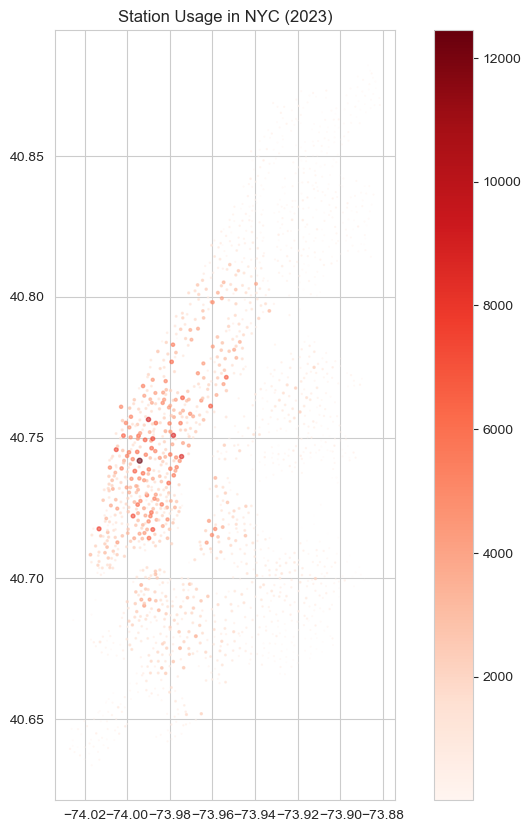

In [35]:
# This is a conceptual example, not fully functional without basemap data and geopandas
# Uncomment and run only if you have geopandas and a suitable background map.


import geopandas as gpd
from shapely.geometry import Point

start_station_info = df[['start_station_name','start_lat','start_lng']].drop_duplicates('start_station_name')
station_usage_df = station_usage.reset_index().rename(columns={'index':'station_name',0:'usage'})
stations_map = pd.merge(start_station_info, station_usage_df, left_on='start_station_name', right_on='station_name', how='left')

stations_map['geometry'] = stations_map.apply(lambda x: Point(x['start_lng'], x['start_lat']), axis=1)
gdf = gpd.GeoDataFrame(stations_map, geometry='geometry', crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='usage', cmap='Reds', markersize=gdf['usage']/1000, legend=True, alpha=0.6)
ax.set_title('Station Usage in NYC (2023)')
plt.show()

